In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
!pwd

/content


In [16]:
# !git clone https://github.com/telescopeuser/data.git

Cloning into 'data'...
remote: Counting objects: 9, done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [17]:
!ls -l data

total 75140
-rwxr-xr-x 1 root root 11878108 Mar  8 14:03 fakenews.zip
-rwxr-xr-x 1 root root      438 Mar  8 14:03 README.md
-rwxr-xr-x 1 root root 33795881 Mar  8 14:03 reviews2.pkl
-rwxr-xr-x 1 root root 31344016 Mar  8 14:03 text8.zip


In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# Word2Vec

The point of this lesson is to introduce how to represent categorical variables.

In [0]:
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE

import zipfile
import collections

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data('data/text8.zip')
print('Data size %d' % len(words))
print(words[:10])

Data size 17005207
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [21]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [22]:
%%time
skip_window = 1
instances = len(data) - 2*skip_window
context = np.zeros((instances,skip_window*2+1),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)

k = 0
for i in range(skip_window, len(data)-skip_window):
    context[k] = data[i-skip_window:i+skip_window+1] # Get surrounding words
    labels[k] = data[i] # Get target variable
    k += 1
    
context = np.delete(context,skip_window,1) # delete the middle word
    
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<instances:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (instances-data_idx)
        batch_labels = np.vstack([labels[data_idx:instances],labels[:overlay]])
        batch_word_data = np.vstack([context[data_idx:instances],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data

CPU times: user 26 s, sys: 38 ms, total: 26.1 s
Wall time: 26.1 s


In [23]:
print( [reverse_dictionary[bi] for bi in data[:40]])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to']


In [24]:
labels_, batch = generate_batch(20)
print('\n    batch:', [reverse_dictionary[bi] for bi in batch.ravel()])
print('\n    labels:', [reverse_dictionary[li] for li in labels_.ravel()])


    batch: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of', 'term', 'abuse', 'of', 'first', 'abuse', 'used', 'first', 'against', 'used', 'early', 'against', 'working', 'early', 'class', 'working', 'radicals', 'class', 'including', 'radicals', 'the', 'including', 'diggers', 'the', 'of', 'diggers', 'the', 'of', 'english', 'the', 'revolution', 'english', 'and']

    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution']


Shuffle the data:

In [0]:
data_idx = 0
shuffle_idx = np.random.permutation(instances) # create a random permutation to shuffle
labels = labels[shuffle_idx]
context = context[shuffle_idx]

## Tensorflow model: (Continuous Bag of Words - CBoW)

In [26]:
context_window = 2*skip_window
batch_size = 128*context_window
embedding_size = 128 # Dimension of the embedding vector.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_examples = np.random.choice(100,16,replace=False) # Choose 16 words from top 100
num_sampled = 64 # Number of negative examples to sample.

sum_ids = np.repeat(np.arange(batch_size/context_window, dtype=np.int32),context_window)

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size/context_window, 1])
    segment_ids = tf.constant(sum_ids, dtype=tf.int32)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]),trainable=False)

    # Model.
    # Look up embeddings for inputs.
    embed = tf.segment_mean(tf.nn.embedding_lookup(embeddings, train_dataset),segment_ids)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, inputs=embed,
                                   labels = train_labels, num_sampled = num_sampled, num_classes = vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [27]:
num_steps = 100001

with tf.Session(graph=graph) as session:
#     tf.initialize_all_variables().run()
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_data = generate_batch(int(batch_size/context_window))
        feed_dict = {train_dataset : batch_data.ravel(), train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        ############
        # Calculate average loss (every 2000 steps)
        ################
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        ####################
        
        ##################
        # Check with the validation set (every 10000 steps)
        ##################
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(len(valid_examples)):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word) # append the k-the nearest word
                print(log)

    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.667565
Nearest to only: inescapable, luciano, slapped, cardiology, argos, faceless, dynamite, fourteenth,
Nearest to i: pagerank, wirth, rainforests, tends, barbarossa, perineum, adage, irregularity,
Nearest to years: hurrian, ornamentation, warrington, absorptive, crouch, economist, czarist, undertones,
Nearest to will: iconography, peppers, operand, beaux, nernst, macrophages, nanomachines, shaving,
Nearest to about: affairs, functionals, crewmembers, outcomes, supply, presumed, witnessing, burning,
Nearest to in: front, shoes, mycenaean, caltrans, comments, diary, nationality, montag,
Nearest to of: punic, caesura, sabra, parmenides, griese, jadavpur, disk, subshell,
Nearest to however: companions, bohm, glace, pathogenic, pulling, connective, incubation, obtainable,
Nearest to all: hanover, nord, rolfe, dredging, bungee, nozzles, enrollments, lydia,
Nearest to to: dashing, macrovision, complicated, lender, permittivity, gasp, copied, bcp,
Neare

Average loss at step 42000: 2.982693
Average loss at step 44000: 2.971617
Average loss at step 46000: 2.947485
Average loss at step 48000: 2.943012
Average loss at step 50000: 2.927886
Nearest to only: expected, severed, bhopal, all, filmi, malts, bashar, least,
Nearest to i: ii, you, we, xii, rafael, delta, kristian, she,
Nearest to years: days, months, minutes, centuries, year, hours, times, ornamentation,
Nearest to will: would, can, could, should, must, cannot, might, may,
Nearest to about: outcomes, csv, jurisdictional, that, sm, kowloon, over, mccarthy,
Nearest to in: within, during, at, under, near, montag, on, caltrans,
Nearest to of: sabra, spatially, rosetta, although, supports, stromata, sica, lacrosse,
Nearest to however: but, though, although, that, hewson, papua, while, lean,
Nearest to all: various, several, both, some, kpd, many, these, any,
Nearest to to: dashing, will, onto, mh, should, gasp, permittivity, must,
Nearest to nine: eight, seven, six, four, five, three, z

Average loss at step 94000: 2.760799
Average loss at step 96000: 2.757627
Average loss at step 98000: 2.750515
Average loss at step 100000: 2.745184
Nearest to only: bhopal, polling, normally, bashar, malts, altercation, all, either,
Nearest to i: ii, we, you, nothing, iii, xii, they, iv,
Nearest to years: days, months, minutes, centuries, hours, decades, year, seconds,
Nearest to will: would, could, should, can, must, may, might, cannot,
Nearest to about: outcomes, over, steps, sm, falklands, csv, jurisdictional, approximately,
Nearest to in: within, during, at, near, throughout, on, under, among,
Nearest to of: sabra, spatially, including, doric, obverse, stromata, sica, in,
Nearest to however: but, although, though, that, while, except, moreover, today,
Nearest to all: various, both, many, several, identical, some, numerous, kpd,
Nearest to to: dashing, onto, will, gasp, must, mh, permittivity, towards,
Nearest to nine: eight, seven, six, five, four, three, zero, two,
Nearest to war

In [28]:
final_embeddings.shape

(50000, 128)

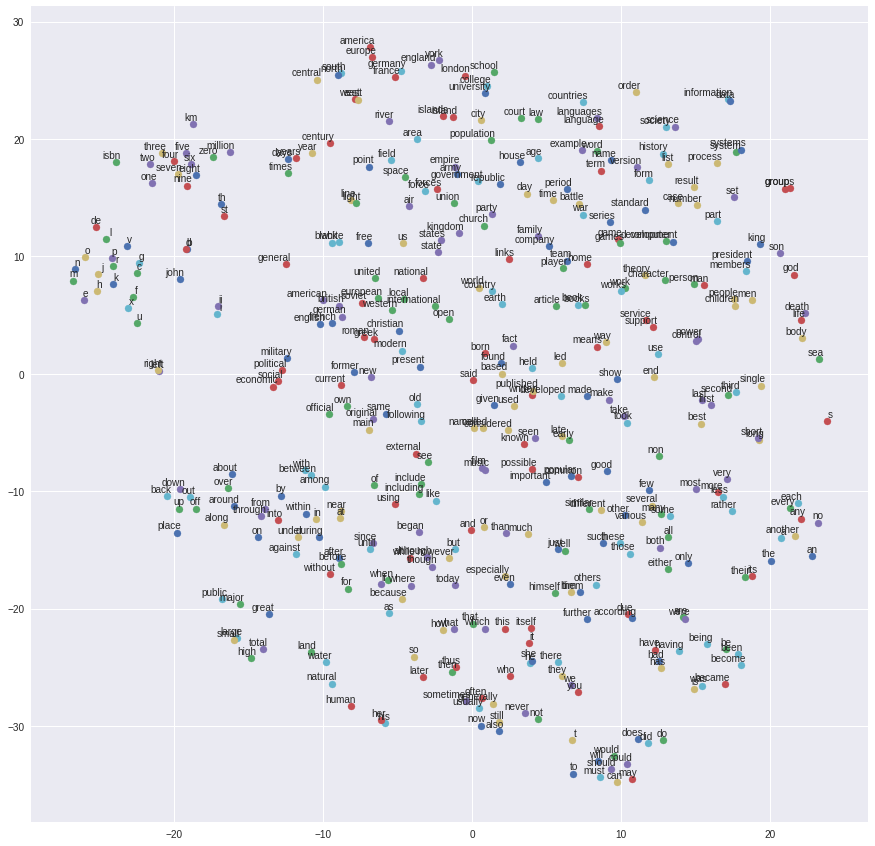

In [29]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---